In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.transforms as transforms
from torchvision.models import resnet18
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, 
    confusion_matrix, roc_auc_score, roc_curve, silhouette_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

import os
import glob
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


2025-12-02 15:51:38.211791: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764690698.384061      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764690698.435401      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Using device: cuda


# Dataset Preparation

In [2]:
class NestedImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Root directory containing class-wise folders.
            transform: Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        # Get class names and create mapping
        class_names = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}
        self.idx_to_class = {idx: cls for cls, idx in self.class_to_idx.items()}
        
        # Collect all image paths and labels
        for class_name in class_names:
            class_folder = os.path.join(root_dir, class_name)
            if os.path.isdir(class_folder):
                for img_path in glob.glob(os.path.join(class_folder, '**', '*.*'), recursive=True):
                    if img_path.lower().endswith(('.jpg', '.jpeg', '.png')): 
                        self.image_paths.append(img_path)
                        self.labels.append(self.class_to_idx[class_name])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


# Load dataset
root_dir = '/kaggle/input/wheatvarieties/Wheat varieties dataset-20240912T042219Z-001/Wheat varieties dataset'
dataset = NestedImageDataset(root_dir=root_dir)
print(f"Total samples in the dataset: {len(dataset)}")
print(f"Number of classes: {len(dataset.class_to_idx)}")
print(f"Class names: {list(dataset.class_to_idx.keys())}")

# Check samples
for i in range(min(5, len(dataset))):  
    img, label = dataset[i]
    print(f"Sample {i}: Label {label} ({dataset.idx_to_class[label]}), Type: {type(img)}")


# Calculate dataset statistics for normalization
print("\nCalculating dataset statistics...")
temp_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
temp_dataset = NestedImageDataset(root_dir=root_dir, transform=temp_transform)
temp_loader = DataLoader(temp_dataset, batch_size=32, shuffle=False, num_workers=2)

mean = torch.zeros(3)
std = torch.zeros(3)
total_images = 0

for images, _ in tqdm(temp_loader, desc="Computing mean/std"):
    batch_size = images.size(0)
    images = images.view(batch_size, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images += batch_size

mean /= total_images
std /= total_images
print(f"Dataset Mean: {mean}")
print(f"Dataset Std: {std}")


# Split dataset into train and test
if len(dataset.image_paths) > 0:
    train_indices, test_indices = train_test_split(
        range(len(dataset)), 
        test_size=0.2, 
        random_state=42,
        stratify=dataset.labels
    )
    
    print(f"\nTrain samples: {len(train_indices)}")
    print(f"Test samples: {len(test_indices)}")
else:
    print("No images found. Please check your directory structure.")
    raise ValueError("Dataset is empty!")


# Base transform for evaluation
transform_base = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

Total samples in the dataset: 375
Number of classes: 3
Class names: ['Akbar', 'Dilkash', 'urooj']
Sample 0: Label 0 (Akbar), Type: <class 'PIL.Image.Image'>
Sample 1: Label 0 (Akbar), Type: <class 'PIL.Image.Image'>
Sample 2: Label 0 (Akbar), Type: <class 'PIL.Image.Image'>
Sample 3: Label 0 (Akbar), Type: <class 'PIL.Image.Image'>
Sample 4: Label 0 (Akbar), Type: <class 'PIL.Image.Image'>

Calculating dataset statistics...


Computing mean/std: 100%|██████████| 12/12 [00:01<00:00,  6.82it/s]

Dataset Mean: tensor([0.4922, 0.4628, 0.4575])
Dataset Std: tensor([0.0751, 0.0704, 0.0530])

Train samples: 300
Test samples: 75


# Barlow Twins Augmentation Pipeline

In [8]:
class BarlowTwinsAugmentation:
    """
    Barlow Twins uses strong augmentations to create two different views.
    Augmentation recipe: random crop, flip, color jitter, grayscale, blur, solarization
    """
    def __init__(self, size=224):
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(size=size, scale=(0.08, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.2, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0)),
            transforms.RandomSolarize(threshold=128, p=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean.tolist(), std=std.tolist())
        ])
    
    def __call__(self, x):
        return self.transform(x), self.transform(x)


class BarlowTwinsDataset(Dataset):
    """Wrapper dataset that applies Barlow Twins augmentations"""
    def __init__(self, base_dataset, indices):
        self.base_dataset = base_dataset
        self.indices = indices
        self.augment = BarlowTwinsAugmentation()
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        img_path = self.base_dataset.image_paths[real_idx]
        label = self.base_dataset.labels[real_idx]
        img = Image.open(img_path).convert("RGB")
        
        view1, view2 = self.augment(img)
        return view1, view2, label


barlow_train_dataset = BarlowTwinsDataset(dataset, train_indices)
barlow_train_loader = DataLoader(
    barlow_train_dataset, 
    batch_size=128,  
    shuffle=True, 
    num_workers=2, 
    pin_memory=True
)



# Barlow Twins Model Architecture

In [3]:
class BarlowTwins(nn.Module):
    """
    Barlow Twins model with ResNet18 encoder and projector head.
    The projector maps features to a higher-dimensional space where
    the redundancy reduction objective is applied.
    """
    def __init__(self, projection_dim=8192, hidden_dim=8192):
        super(BarlowTwins, self).__init__()
        
        # Encoder: ResNet18 backbone
        self.encoder = resnet18(pretrained=False)
        self.encoder.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Get feature dimension
        self.feature_dim = self.encoder.fc.in_features
        self.encoder.fc = nn.Identity()
        
        # Projector: 3-layer MLP
        self.projector = nn.Sequential(
            nn.Linear(self.feature_dim, hidden_dim, bias=False),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim, bias=False),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, projection_dim, bias=False)
        )
    
    def forward(self, x):
        h = self.encoder(x)  # Features from encoder
        z = self.projector(h)  # Projected features
        return h, z


model = BarlowTwins(projection_dim=8192, hidden_dim=8192).to(device)
print(f"Encoder feature dimension: {model.feature_dim}")
print(f"Projection dimension: 8192")

Encoder feature dimension: 512
Projection dimension: 8192


In [6]:
def barlow_twins_loss(z1, z2, lambda_param=0.0051):
    """
    Barlow Twins loss: encourages the cross-correlation matrix between 
    the embeddings to be close to the identity matrix.
    
    Args:
        z1, z2: Projected features from two views (batch_size x projection_dim)
        lambda_param: Weight of the off-diagonal terms (redundancy reduction)
    """
    batch_size = z1.size(0)
    
    # Normalize the representations along the batch dimension
    z1_norm = (z1 - z1.mean(0)) / z1.std(0)
    z2_norm = (z2 - z2.mean(0)) / z2.std(0)
    
    # Compute cross-correlation matrix
    c = torch.mm(z1_norm.T, z2_norm) / batch_size
    
    # Loss: on-diagonal terms (should be close to 1) + off-diagonal terms (should be close to 0)
    on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()
    off_diag = c.pow_(2).sum() - torch.diagonal(c).pow_(2).sum()
    
    loss = on_diag + lambda_param * off_diag
    
    return loss

# 5.1 Label free Pretrainning

In [9]:
def train_barlow_twins(model, train_loader, epochs=100, lr=1e-3, lambda_param=0.0051):
    """
    Pretrain Barlow Twins using redundancy reduction objective
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    model.train()
    losses = []
    
    print("Starting Barlow Twins pretraining...")
    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        
        for view1, view2, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            view1, view2 = view1.to(device), view2.to(device)
            
            # Forward pass
            _, z1 = model(view1)
            _, z2 = model(view2)
            
            # Compute loss
            loss = barlow_twins_loss(z1, z2, lambda_param=lambda_param)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
    
    train_time = time.time() - start_time
    print(f"Pretraining completed in {train_time:.2f} seconds")
    
    return losses, train_time


# Train the model
pretrain_losses, pretrain_time = train_barlow_twins(
    model, 
    barlow_train_loader, 
    epochs=50,
    lr=1e-3,
    lambda_param=0.0051
)

# Save the pretrained encoder
torch.save(model.encoder.state_dict(), 'barlow_twins_encoder.pth')
print("Frozen encoder saved!")

Starting Barlow Twins pretraining...


Epoch 1/50: 100%|██████████| 3/3 [00:21<00:00,  7.33s/it]


Epoch 1/50 - Loss: 13267.3027


Epoch 2/50: 100%|██████████| 3/3 [00:23<00:00,  7.85s/it]


Epoch 2/50 - Loss: 19559.5241


Epoch 3/50: 100%|██████████| 3/3 [00:26<00:00,  8.98s/it]


Epoch 3/50 - Loss: 18379.4798


Epoch 4/50: 100%|██████████| 3/3 [00:22<00:00,  7.60s/it]


Epoch 4/50 - Loss: 14036.1299


Epoch 5/50: 100%|██████████| 3/3 [00:22<00:00,  7.59s/it]


Epoch 5/50 - Loss: 12537.8678


Epoch 6/50: 100%|██████████| 3/3 [00:25<00:00,  8.36s/it]


Epoch 6/50 - Loss: 32003.7773


Epoch 7/50: 100%|██████████| 3/3 [00:22<00:00,  7.46s/it]


Epoch 7/50 - Loss: 14067.2207


Epoch 8/50: 100%|██████████| 3/3 [00:24<00:00,  8.07s/it]


Epoch 8/50 - Loss: 10081.3517


Epoch 9/50: 100%|██████████| 3/3 [00:21<00:00,  7.30s/it]


Epoch 9/50 - Loss: 14150.4176


Epoch 10/50: 100%|██████████| 3/3 [00:21<00:00,  7.27s/it]


Epoch 10/50 - Loss: 13390.7887


Epoch 11/50: 100%|██████████| 3/3 [00:26<00:00,  8.69s/it]


Epoch 11/50 - Loss: 12365.0723


Epoch 12/50: 100%|██████████| 3/3 [00:25<00:00,  8.65s/it]


Epoch 12/50 - Loss: 13070.7891


Epoch 13/50: 100%|██████████| 3/3 [00:24<00:00,  8.13s/it]


Epoch 13/50 - Loss: 11479.2822


Epoch 14/50: 100%|██████████| 3/3 [00:24<00:00,  8.07s/it]


Epoch 14/50 - Loss: 9203.8722


Epoch 15/50: 100%|██████████| 3/3 [00:25<00:00,  8.42s/it]


Epoch 15/50 - Loss: 11517.0443


Epoch 16/50: 100%|██████████| 3/3 [00:24<00:00,  8.08s/it]


Epoch 16/50 - Loss: 10489.9801


Epoch 17/50: 100%|██████████| 3/3 [00:22<00:00,  7.54s/it]


Epoch 17/50 - Loss: 15104.5459


Epoch 18/50: 100%|██████████| 3/3 [00:24<00:00,  8.20s/it]


Epoch 18/50 - Loss: 13797.1074


Epoch 19/50: 100%|██████████| 3/3 [00:24<00:00,  8.27s/it]


Epoch 19/50 - Loss: 10768.1823


Epoch 20/50: 100%|██████████| 3/3 [00:22<00:00,  7.55s/it]


Epoch 20/50 - Loss: 10668.1553


Epoch 21/50: 100%|██████████| 3/3 [00:23<00:00,  7.75s/it]


Epoch 21/50 - Loss: 13674.1022


Epoch 22/50: 100%|██████████| 3/3 [00:24<00:00,  8.09s/it]


Epoch 22/50 - Loss: 14017.2383


Epoch 23/50: 100%|██████████| 3/3 [00:24<00:00,  8.30s/it]


Epoch 23/50 - Loss: 10910.7982


Epoch 24/50: 100%|██████████| 3/3 [00:22<00:00,  7.34s/it]


Epoch 24/50 - Loss: 11643.5713


Epoch 25/50: 100%|██████████| 3/3 [00:25<00:00,  8.57s/it]


Epoch 25/50 - Loss: 10468.4128


Epoch 26/50: 100%|██████████| 3/3 [00:25<00:00,  8.45s/it]


Epoch 26/50 - Loss: 19726.4521


Epoch 27/50: 100%|██████████| 3/3 [00:24<00:00,  8.07s/it]


Epoch 27/50 - Loss: 12655.1987


Epoch 28/50: 100%|██████████| 3/3 [00:25<00:00,  8.39s/it]


Epoch 28/50 - Loss: 10375.1416


Epoch 29/50: 100%|██████████| 3/3 [00:22<00:00,  7.60s/it]


Epoch 29/50 - Loss: 15641.5798


Epoch 30/50: 100%|██████████| 3/3 [00:23<00:00,  7.91s/it]


Epoch 30/50 - Loss: 12483.2952


Epoch 31/50: 100%|██████████| 3/3 [00:24<00:00,  8.01s/it]


Epoch 31/50 - Loss: 12332.8014


Epoch 32/50: 100%|██████████| 3/3 [00:22<00:00,  7.59s/it]


Epoch 32/50 - Loss: 9885.0114


Epoch 33/50: 100%|██████████| 3/3 [00:24<00:00,  8.08s/it]


Epoch 33/50 - Loss: 16469.7939


Epoch 34/50: 100%|██████████| 3/3 [00:22<00:00,  7.57s/it]


Epoch 34/50 - Loss: 17570.5410


Epoch 35/50: 100%|██████████| 3/3 [00:23<00:00,  7.82s/it]


Epoch 35/50 - Loss: 12491.7529


Epoch 36/50: 100%|██████████| 3/3 [00:23<00:00,  7.81s/it]


Epoch 36/50 - Loss: 12209.0612


Epoch 37/50: 100%|██████████| 3/3 [00:24<00:00,  8.15s/it]


Epoch 37/50 - Loss: 10202.1390


Epoch 38/50: 100%|██████████| 3/3 [00:22<00:00,  7.62s/it]


Epoch 38/50 - Loss: 15138.0734


Epoch 39/50: 100%|██████████| 3/3 [00:23<00:00,  7.93s/it]


Epoch 39/50 - Loss: 14221.3691


Epoch 40/50: 100%|██████████| 3/3 [00:21<00:00,  7.11s/it]


Epoch 40/50 - Loss: 11557.3936


Epoch 41/50: 100%|██████████| 3/3 [00:23<00:00,  7.75s/it]


Epoch 41/50 - Loss: 10286.7686


Epoch 42/50: 100%|██████████| 3/3 [00:23<00:00,  7.93s/it]


Epoch 42/50 - Loss: 13448.3249


Epoch 43/50: 100%|██████████| 3/3 [00:20<00:00,  6.88s/it]


Epoch 43/50 - Loss: 10945.5929


Epoch 44/50: 100%|██████████| 3/3 [00:23<00:00,  7.72s/it]


Epoch 44/50 - Loss: 15397.3317


Epoch 45/50: 100%|██████████| 3/3 [00:23<00:00,  7.79s/it]


Epoch 45/50 - Loss: 10830.1071


Epoch 46/50: 100%|██████████| 3/3 [00:22<00:00,  7.58s/it]


Epoch 46/50 - Loss: 20947.1546


Epoch 47/50: 100%|██████████| 3/3 [00:24<00:00,  8.15s/it]


Epoch 47/50 - Loss: 10104.4749


Epoch 48/50: 100%|██████████| 3/3 [00:21<00:00,  7.28s/it]


Epoch 48/50 - Loss: 11641.2790


Epoch 49/50: 100%|██████████| 3/3 [00:25<00:00,  8.38s/it]


Epoch 49/50 - Loss: 10095.8965


Epoch 50/50: 100%|██████████| 3/3 [00:23<00:00,  7.80s/it]

Epoch 50/50 - Loss: 9280.5778
Pretraining completed in 1184.69 seconds
Frozen encoder saved!


# Extract Features from Encoder

In [10]:
def extract_features(model, dataset, indices, transform, batch_size=128):
    """
    Extract features from the frozen encoder
    """
    model.eval()
    features = []
    labels = []
    
    # Create temporary dataset with transform
    temp_dataset = NestedImageDataset(root_dir=dataset.root_dir, transform=transform)
    temp_dataset.image_paths = [dataset.image_paths[i] for i in indices]
    temp_dataset.labels = [dataset.labels[i] for i in indices]
    
    temp_loader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    with torch.no_grad():
        for imgs, lbls in tqdm(temp_loader, desc="Extracting features"):
            imgs = imgs.to(device)
            h, _ = model(imgs)
            features.append(h.cpu().numpy())
            labels.append(lbls.numpy())
    
    features = np.vstack(features)
    labels = np.concatenate(labels)
    
    return features, labels


# Extract features
print("Extracting training features...")
X_train, y_train = extract_features(model, dataset, train_indices, transform_base)
print(f"Train features shape: {X_train.shape}")

print("Extracting test features...")
X_test, y_test = extract_features(model, dataset, test_indices, transform_base)
print(f"Test features shape: {X_test.shape}")


Extracting training features...


Extracting features: 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Train features shape: (300, 512)
Extracting test features...


Extracting features: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

Test features shape: (75, 512)


# 5.2 Downstream Evaluation- Linear Probe

In [11]:
def train_linear_probe(X_train, y_train, X_test, y_test):
    """
    Train a linear classifier on frozen features
    This is the primary SSL evaluation metric
    """
    print("\n=== Linear Probe Evaluation ===")
    start_time = time.time()
    
    clf = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    test_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Linear Probe Accuracy: {accuracy:.4f}")
    print(f"Train time: {train_time:.2f}s, Test time: {test_time:.2f}s")
    
    return clf, y_pred, y_pred_proba, accuracy, train_time, test_time


linear_probe, linear_pred, linear_proba, linear_acc, lp_train_time, lp_test_time = \
    train_linear_probe(X_train, y_train, X_test, y_test)




=== Linear Probe Evaluation ===
Linear Probe Accuracy: 0.7200
Train time: 1.51s, Test time: 0.01s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 5.2 Downstream Evaluation- Shallow Heads

In [12]:
def evaluate_shallow_heads(X_train, y_train, X_test, y_test):
    """
    Train various shallow classifiers on frozen features
    """
    results = {}
    
    # MLP
    print("\n=== MLP Classifier ===")
    from sklearn.neural_network import MLPClassifier
    start = time.time()
    mlp = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=300, random_state=42)
    mlp.fit(X_train, y_train)
    train_time = time.time() - start
    
    start = time.time()
    mlp_pred = mlp.predict(X_test)
    test_time = time.time() - start
    mlp_acc = accuracy_score(y_test, mlp_pred)
    print(f"MLP Accuracy: {mlp_acc:.4f}")
    results['MLP'] = {'accuracy': mlp_acc, 'train_time': train_time, 
                      'test_time': test_time, 'predictions': mlp_pred}
    
    # SVM
    print("\n=== SVM Classifier ===")
    start = time.time()
    svm = SVC(kernel='rbf', random_state=42)
    # Use subset if dataset is large
    train_size = min(5000, len(X_train))
    svm.fit(X_train[:train_size], y_train[:train_size])
    train_time = time.time() - start
    
    start = time.time()
    svm_pred = svm.predict(X_test)
    test_time = time.time() - start
    svm_acc = accuracy_score(y_test, svm_pred)
    print(f"SVM Accuracy: {svm_acc:.4f}")
    results['SVM'] = {'accuracy': svm_acc, 'train_time': train_time, 
                      'test_time': test_time, 'predictions': svm_pred}
    
    # Decision Tree
    print("\n=== Decision Tree Classifier ===")
    start = time.time()
    dt = DecisionTreeClassifier(max_depth=20, random_state=42)
    dt.fit(X_train, y_train)
    train_time = time.time() - start
    
    start = time.time()
    dt_pred = dt.predict(X_test)
    test_time = time.time() - start
    dt_acc = accuracy_score(y_test, dt_pred)
    print(f"Decision Tree Accuracy: {dt_acc:.4f}")
    results['DecisionTree'] = {'accuracy': dt_acc, 'train_time': train_time, 
                               'test_time': test_time, 'predictions': dt_pred}
    
    # Random Forest
    print("\n=== Random Forest Classifier ===")
    start = time.time()
    rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_time = time.time() - start
    
    start = time.time()
    rf_pred = rf.predict(X_test)
    test_time = time.time() - start
    rf_acc = accuracy_score(y_test, rf_pred)
    print(f"Random Forest Accuracy: {rf_acc:.4f}")
    results['RandomForest'] = {'accuracy': rf_acc, 'train_time': train_time, 
                               'test_time': test_time, 'predictions': rf_pred}
    
    return results


shallow_results = evaluate_shallow_heads(X_train, y_train, X_test, y_test)


=== MLP Classifier ===
MLP Accuracy: 0.7200

=== SVM Classifier ===
SVM Accuracy: 0.6667

=== Decision Tree Classifier ===
Decision Tree Accuracy: 0.6133

=== Random Forest Classifier ===
Random Forest Accuracy: 0.7467


# 5.2 Downstream Evaluation - Full Fine Tuning

In [13]:
def full_finetune(model, dataset, train_indices, test_indices, num_classes, epochs=20, lr=1e-3):
    """
    Fine-tune the entire encoder end-to-end
    Compare with linear probe to see if fine-tuning helps
    """
    print("\n=== Full Fine-tuning ===")
    
    # Create a classifier on top of encoder
    class FineTuneModel(nn.Module):
        def __init__(self, encoder, num_classes):
            super().__init__()
            self.encoder = encoder
            self.fc = nn.Linear(512, num_classes)  # ResNet18 output is 512
        
        def forward(self, x):
            h = self.encoder(x)
            return self.fc(h)
    
    finetune_model = FineTuneModel(model.encoder, num_classes).to(device)
    
    # Create dataloaders
    train_ds = NestedImageDataset(root_dir=dataset.root_dir, transform=transform_base)
    train_ds.image_paths = [dataset.image_paths[i] for i in train_indices]
    train_ds.labels = [dataset.labels[i] for i in train_indices]
    
    test_ds = NestedImageDataset(root_dir=dataset.root_dir, transform=transform_base)
    test_ds.image_paths = [dataset.image_paths[i] for i in test_indices]
    test_ds.labels = [dataset.labels[i] for i in test_indices]
    
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(finetune_model.parameters(), lr=lr)
    
    start_time = time.time()
    
    for epoch in range(epochs):
        finetune_model.train()
        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            imgs, labels = imgs.to(device), labels.to(device)
            
            outputs = finetune_model(imgs)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    train_time = time.time() - start_time
    
    # Evaluate
    finetune_model.eval()
    correct = 0
    total = 0
    
    start_time = time.time()
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = finetune_model(imgs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_time = time.time() - start_time
    
    accuracy = correct / total
    print(f"Fine-tuning Accuracy: {accuracy:.4f}")
    print(f"Improvement over Linear Probe: {(accuracy - linear_acc):.4f}")
    print(f"Train time: {train_time:.2f}s, Test time: {test_time:.2f}s")
    
    return accuracy, train_time, test_time


num_classes = len(dataset.class_to_idx)
finetune_acc, ft_train_time, ft_test_time = full_finetune(
    model, dataset, train_indices, test_indices, num_classes, epochs=20
)





=== Full Fine-tuning ===


Epoch 20/20: 100%|██████████| 5/5 [00:00<00:00,  5.94it/s]


Fine-tuning Accuracy: 0.7467
Improvement over Linear Probe: 0.0267
Train time: 17.32s, Test time: 0.43s


# 5.3 Embedding Analysis- t-SNE


=== t-SNE Visualization ===


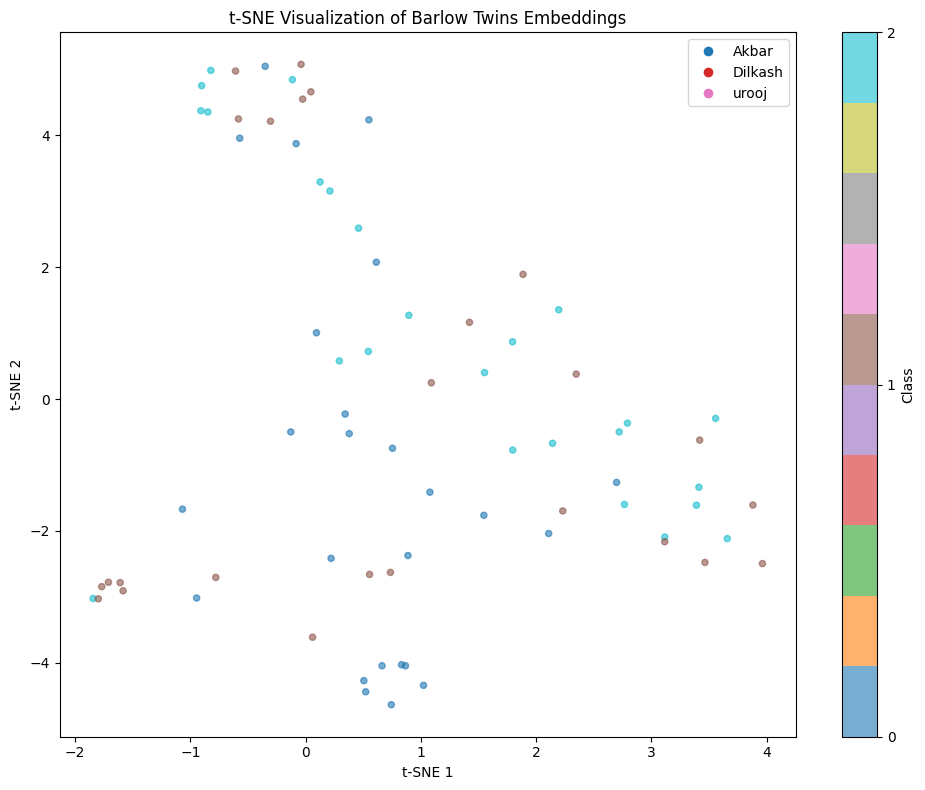

t-SNE Silhouette Score: -0.0108


In [14]:
def plot_tsne(features, labels, class_names, n_samples=None):
    """
    Create t-SNE visualization of embeddings colored by true labels
    """
    print("\n=== t-SNE Visualization ===")
    
    # Subsample if dataset is large
    if n_samples is None or n_samples > len(features):
        n_samples = len(features)
    
    if n_samples < len(features):
        indices = np.random.choice(len(features), n_samples, replace=False)
        features_sub = features[indices]
        labels_sub = labels[indices]
    else:
        features_sub = features
        labels_sub = labels
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(features_sub)-1))
    features_2d = tsne.fit_transform(features_sub)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                         c=labels_sub, cmap='tab10', alpha=0.6, s=20)
    plt.colorbar(scatter, label='Class', ticks=range(len(class_names)))
    plt.title('t-SNE Visualization of Barlow Twins Embeddings')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    
    # Add legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', 
               markerfacecolor=plt.cm.tab10(i/len(class_names)), 
               markersize=8, label=name) 
               for i, name in enumerate(class_names)]
    plt.legend(handles=handles, loc='best')
    
    plt.tight_layout()
    plt.savefig('tsne_barlow_twins.png', dpi=150)
    plt.show()
    
    # Compute Silhouette score
    sil_score = silhouette_score(features_2d, labels_sub)
    print(f"t-SNE Silhouette Score: {sil_score:.4f}")
    
    return features_2d, sil_score


class_names = [dataset.idx_to_class[i] for i in range(len(dataset.class_to_idx))]
tsne_features, tsne_sil = plot_tsne(X_test, y_test, class_names)



# 5.3 Embedding Analysis - UMAP

In [16]:
import umap.umap_ as umap_module

_original_check_array = umap_module.check_array

# Create a wrapper that removes ensure_all_finite
def _patched_check_array(X, **kwargs):
    if "ensure_all_finite" in kwargs:
        kwargs.pop("ensure_all_finite")
    return _original_check_array(X, **kwargs)

# Patch UMAP globally
umap_module.check_array = _patched_check_array

print("UMAP check_array patched successfully.")


UMAP check_array patched successfully.



=== UMAP Visualization ===


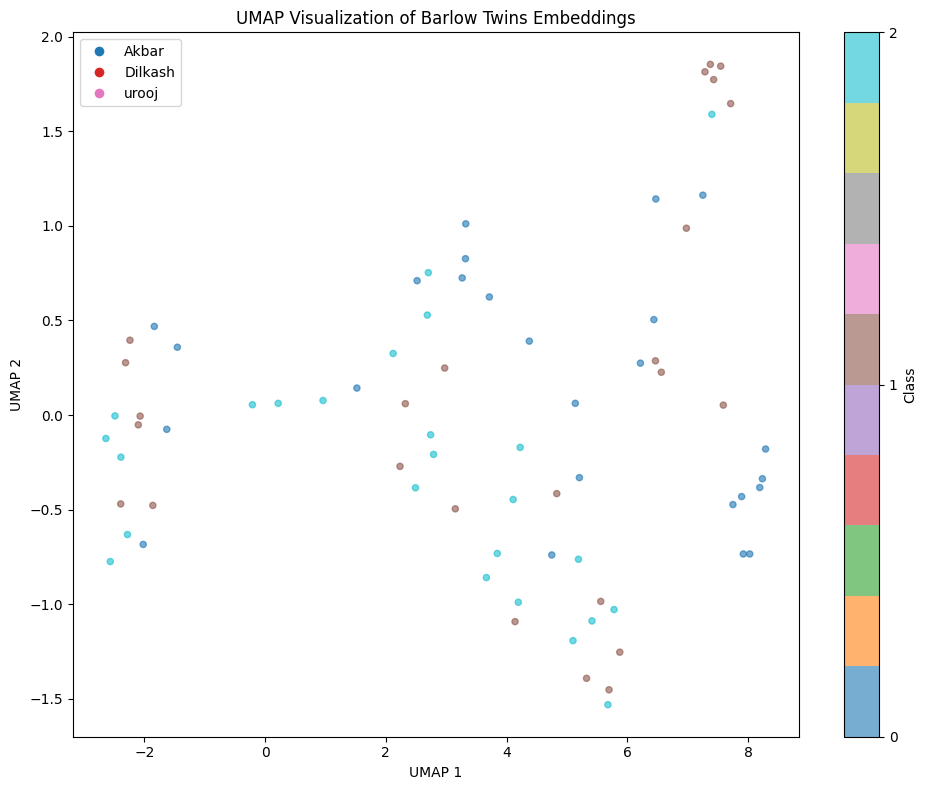

UMAP Silhouette Score: -0.0369


In [17]:
def plot_umap(features, labels, class_names, n_samples=None):
    """
    Create UMAP visualization of embeddings colored by true labels
    """
    print("\n=== UMAP Visualization ===")
    
    # Subsample if dataset is large
    if n_samples is None or n_samples > len(features):
        n_samples = len(features)
    
    if n_samples < len(features):
        indices = np.random.choice(len(features), n_samples, replace=False)
        features_sub = features[indices]
        labels_sub = labels[indices]
    else:
        features_sub = features
        labels_sub = labels
    
    n_neighbors = min(15, len(features_sub) - 1)
    umap = UMAP(n_components=2, random_state=42, n_neighbors=n_neighbors, min_dist=0.1)
    features_2d = umap.fit_transform(features_sub)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                         c=labels_sub, cmap='tab10', alpha=0.6, s=20)
    plt.colorbar(scatter, label='Class', ticks=range(len(class_names)))
    plt.title('UMAP Visualization of Barlow Twins Embeddings')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    
    # Add legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', 
               markerfacecolor=plt.cm.tab10(i/len(class_names)), 
               markersize=8, label=name) 
               for i, name in enumerate(class_names)]
    plt.legend(handles=handles, loc='best')
    
    plt.tight_layout()
    plt.savefig('umap_barlow_twins.png', dpi=150)
    plt.show()
    
    # Compute Silhouette score
    sil_score = silhouette_score(features_2d, labels_sub)
    print(f"UMAP Silhouette Score: {sil_score:.4f}")
    
    return features_2d, sil_score


umap_features, umap_sil = plot_umap(X_test, y_test, class_names)

# 5.3 Embedding Analysis - PCA


=== PCA Visualization ===


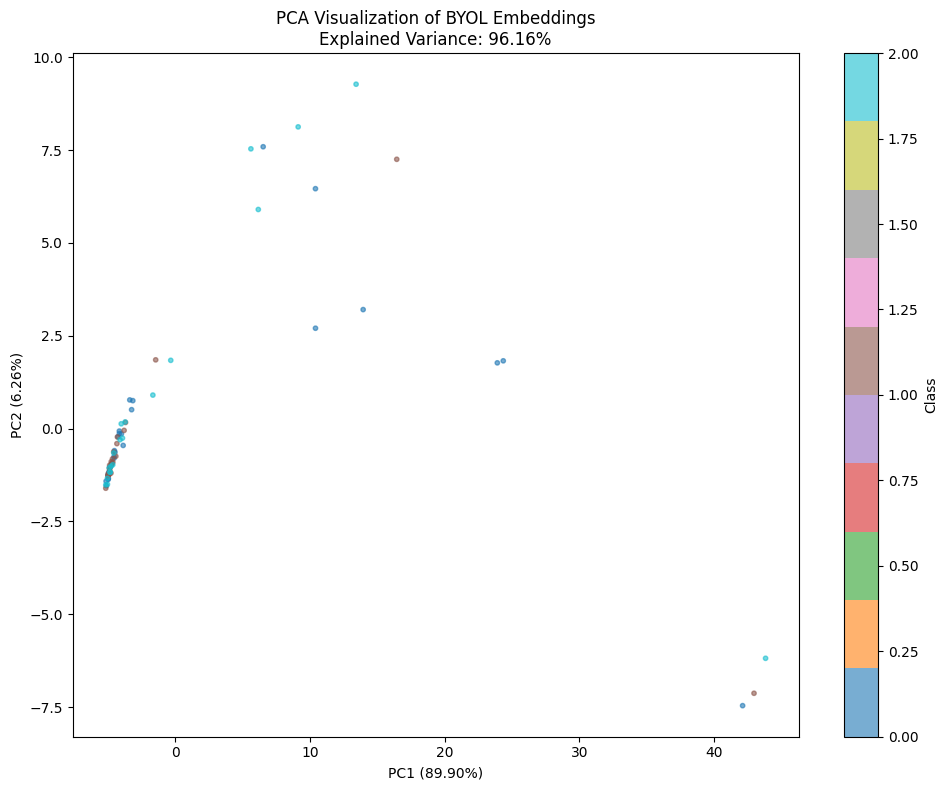

PCA Silhouette Score: -0.1176


In [33]:
def plot_pca(features, labels):
    """
    Create PCA visualization of embeddings colored by true labels
    """
    print("\n=== PCA Visualization ===")
    
    pca = PCA(n_components=2, random_state=42)
    features_2d = pca.fit_transform(features)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                         c=labels, cmap='tab10', alpha=0.6, s=10)
    plt.colorbar(scatter, label='Class')
    plt.title(f'PCA Visualization of BYOL Embeddings\n'
              f'Explained Variance: {pca.explained_variance_ratio_.sum():.2%}')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    plt.tight_layout()
    plt.savefig('pca_byol.png', dpi=150)
    plt.show()
    
    # Compute Silhouette score
    sil_score = silhouette_score(features_2d, labels)
    print(f"PCA Silhouette Score: {sil_score:.4f}")
    
    return features_2d, sil_score


pca_features, pca_sil = plot_pca(X_test, y_test)


# 5.4 Evaluation Metrics - Detailed Evaluation


=== Detailed Metrics ===
Overall Accuracy: 0.7200

Per-Class Metrics:
Class                Precision    Recall       F1-Score     Support     
--------------------------------------------------------------------------------
Akbar                0.9500       0.7600       0.8444       25          
Dilkash              0.6522       0.6000       0.6250       25          
urooj                0.6250       0.8000       0.7018       25          

Macro Avg            0.7424       0.7200       0.7237      


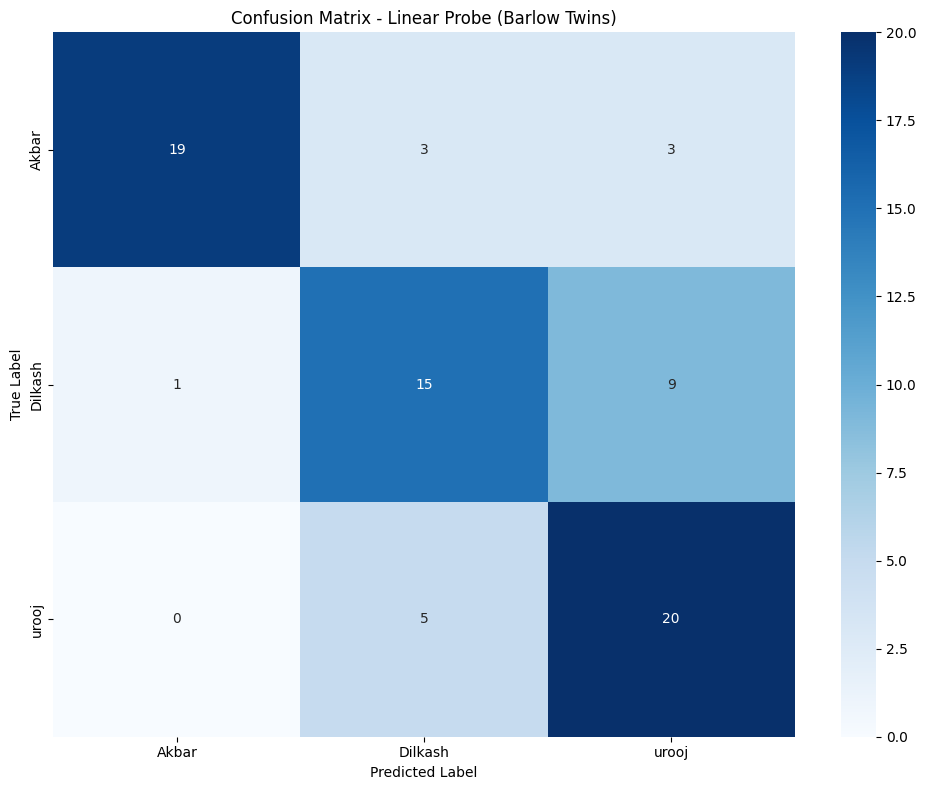

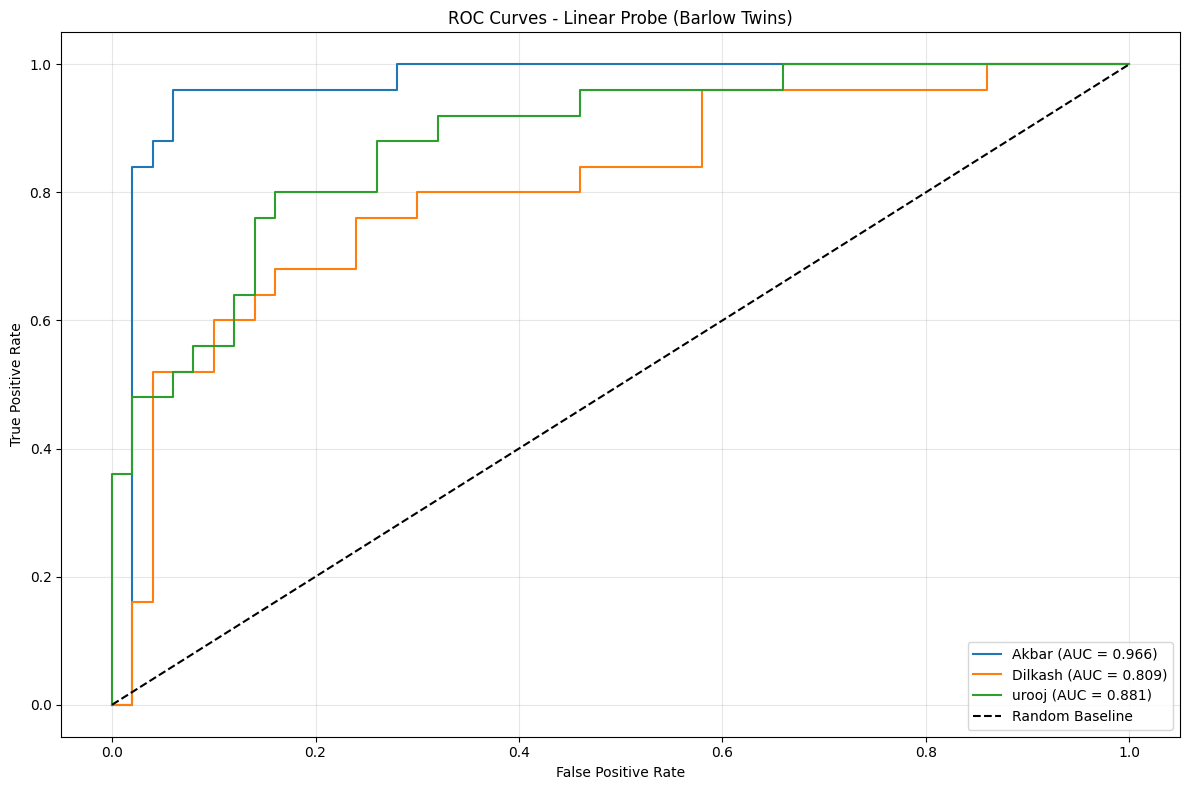


Average ROC-AUC: 0.8851


In [19]:
def compute_detailed_metrics(y_true, y_pred, y_pred_proba, class_names):
    """
    Compute comprehensive classification metrics.
    """

    print("\n=== Detailed Metrics ===")

    # Overall accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Overall Accuracy: {accuracy:.4f}")

    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None
    )

    print("\nPer-Class Metrics:")
    print(f"{'Class':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<12}")
    print("-" * 80)

    for i, name in enumerate(class_names):
        print(f"{name:<20} {precision[i]:<12.4f} {recall[i]:<12.4f} "
              f"{f1[i]:<12.4f} {support[i]:<12}")

    # Macro averages
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro'
    )
    print(f"\n{'Macro Avg':<20} {prec_macro:<12.4f} "
          f"{rec_macro:<12.4f} {f1_macro:<12.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Linear Probe (Barlow Twins)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix_barlow_twins.png', dpi=150)
    plt.show()

    # ROC-AUC and ROC Curves
    n_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    roc_auc = {}
    plt.figure(figsize=(12, 8))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_pred_proba[:, i])

        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Linear Probe (Barlow Twins)')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('roc_curves_barlow_twins.png', dpi=150)
    plt.show()

    avg_roc_auc = np.mean(list(roc_auc.values()))
    print(f"\nAverage ROC-AUC: {avg_roc_auc:.4f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'avg_roc_auc': avg_roc_auc,
        'confusion_matrix': cm
    }

metrics = compute_detailed_metrics(y_test, linear_pred, linear_proba, class_names)


# 5.4 Evaluation Metrics K-NN Accuracy in Embedding Space

In [20]:
def evaluate_knn(X_train, y_train, X_test, y_test, k_values=[1, 5, 20]):
    """
    Evaluate k-NN classification in embedding space.
    This measures the quality of learned representations.
    """
    print("\n=== k-NN Evaluation ===")
    results = {}

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        results[k] = accuracy
        print(f"k={k}: Accuracy = {accuracy:.4f}")

    return results


# Run evaluation
knn_results = evaluate_knn(X_train, y_train, X_test, y_test)


=== k-NN Evaluation ===
k=1: Accuracy = 0.7467
k=5: Accuracy = 0.7067
k=20: Accuracy = 0.6400


# 5.4 Evaluation Metrics- Label Efficiency Curves


=== Label Efficiency Evaluation ===
1.0% labels (3 samples): Accuracy = 0.4400
5.0% labels (15 samples): Accuracy = 0.5333
10.0% labels (30 samples): Accuracy = 0.6933
25.0% labels (75 samples): Accuracy = 0.6267
50.0% labels (150 samples): Accuracy = 0.7333
100.0% labels (300 samples): Accuracy = 0.7200


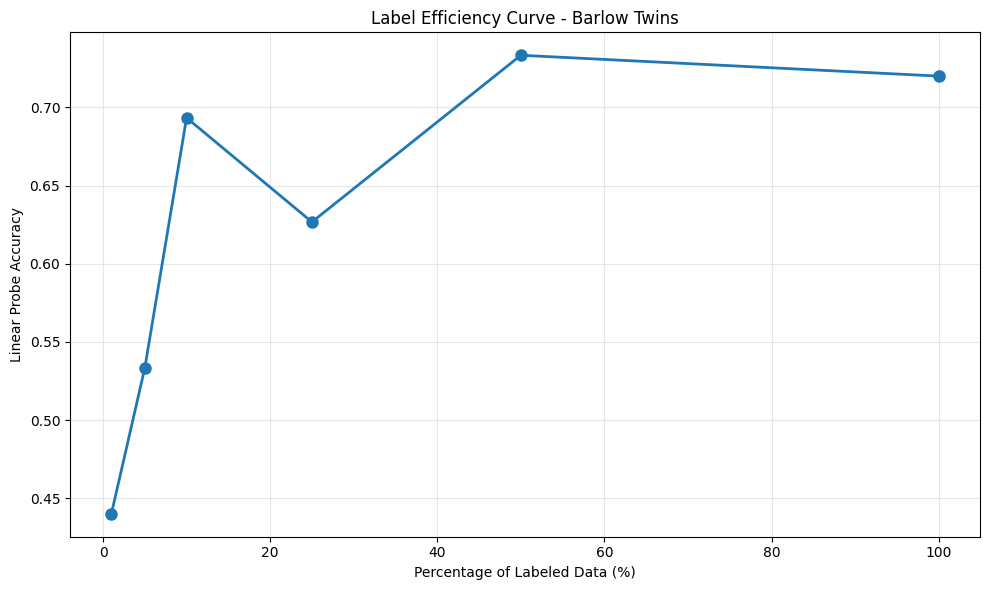

In [21]:
def evaluate_label_efficiency(
        X_train, y_train, X_test, y_test,
        fractions=[0.01, 0.05, 0.1, 0.25, 0.5, 1.0]):
    """
    Evaluate linear probe accuracy with different amounts of labeled data.
    This shows how data-efficient the learned representations are.
    """

    print("\n=== Label Efficiency Evaluation ===")
    results = {}

    for frac in fractions:
        n_samples = max(1, int(len(X_train) * frac))
        n_samples = min(n_samples, len(X_train))

        indices = np.random.choice(len(X_train), n_samples, replace=False)

        X_train_sub = X_train[indices]
        y_train_sub = y_train[indices]

        clf = LogisticRegression(max_iter=1000, random_state=42)
        clf.fit(X_train_sub, y_train_sub)

        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        results[frac] = accuracy
        print(f"{frac*100:.1f}% labels ({n_samples} samples): Accuracy = {accuracy:.4f}")

    # ---- Plot Label Efficiency Curve ----
    plt.figure(figsize=(10, 6))
    fracs_pct = [f * 100 for f in results.keys()]
    accs = list(results.values())

    plt.plot(fracs_pct, accs, marker='o', linewidth=2, markersize=8)
    plt.xlabel('Percentage of Labeled Data (%)')
    plt.ylabel('Linear Probe Accuracy')
    plt.title('Label Efficiency Curve - Barlow Twins')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('label_efficiency_barlow_twins.png', dpi=150)
    plt.show()

    return results


label_efficiency_results = evaluate_label_efficiency(X_train, y_train, X_test, y_test)


# 5.4 Evaluation Metrics- Learning Curves

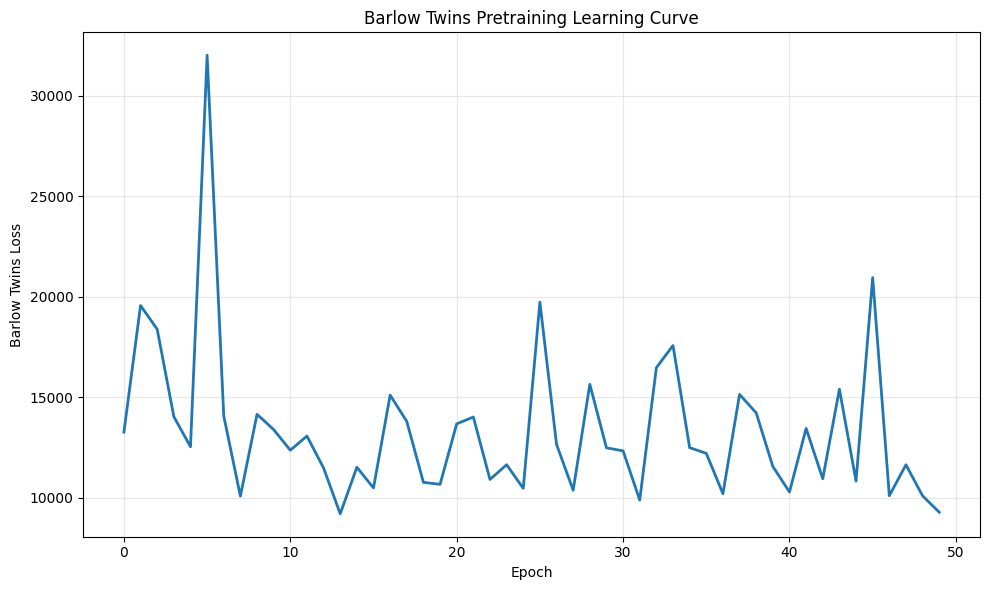

In [22]:
def plot_pretraining_curve(losses):
    """
    Plot the pretraining loss curve.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(losses, linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Barlow Twins Loss')
    plt.title('Barlow Twins Pretraining Learning Curve')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('pretraining_curve_barlow_twins.png', dpi=150)
    plt.show()


# Call function
plot_pretraining_curve(pretrain_losses)

# Comprehensive Results Summary

In [23]:
print("\n" + "="*80)
print("                   BARLOW TWINS COMPREHENSIVE RESULTS")
print("="*80)

# --- PRETRAINING ---
print("\n--- PRETRAINING ---")
print(f"Epochs: 50")
print(f"Pretraining Time: {pretrain_time:.2f}s ({pretrain_time/60:.2f} min)")
print(f"Final Loss: {pretrain_losses[-1]:.4f}")

# --- LINEAR PROBE ---
print("\n--- LINEAR PROBE (Primary SSL Metric) ---")
print(f"Accuracy: {linear_acc:.4f}")
print(f"Train Time: {lp_train_time:.2f}s")
print(f"Test Time: {lp_test_time:.2f}s")

# --- SHALLOW HEADS ---
print("\n--- SHALLOW HEADS ---")
for name, result in shallow_results.items():
    print(f"{name}: Accuracy = {result['accuracy']:.4f}, "
          f"Train Time = {result['train_time']:.2f}s")

# --- FINE-TUNING ---
print("\n--- FULL FINE-TUNING ---")
print(f"Accuracy: {finetune_acc:.4f}")
print(f"Improvement over Linear Probe: {(finetune_acc - linear_acc):.4f}")
print(f"Train Time: {ft_train_time:.2f}s ({ft_train_time/60:.2f} min)")

# --- EMBEDDING QUALITY ---
print("\n--- EMBEDDING QUALITY (Silhouette Scores) ---")
print(f"t-SNE: {tsne_sil:.4f}")
print(f"UMAP: {umap_sil:.4f}")
print(f"PCA:  {pca_sil:.4f}")

# --- k-NN ---
print("\n--- k-NN ACCURACY ---")
for k, acc in knn_results.items():
    print(f"k={k}: {acc:.4f}")

# --- LABEL EFFICIENCY ---
print("\n--- LABEL EFFICIENCY ---")
for frac, acc in label_efficiency_results.items():
    print(f"{frac*100:.1f}% labels: {acc:.4f}")

# --- DETAILED METRICS ---
print("\n--- DETAILED METRICS (Linear Probe) ---")
print(f"Average Precision: {metrics['precision'].mean():.4f}")
print(f"Average Recall:    {metrics['recall'].mean():.4f}")
print(f"Average F1-Score:  {metrics['f1'].mean():.4f}")
print(f"Average ROC-AUC:   {metrics['avg_roc_auc']:.4f}")

print("\n" + "="*80)



                   BARLOW TWINS COMPREHENSIVE RESULTS

--- PRETRAINING ---
Epochs: 50
Pretraining Time: 1184.69s (19.74 min)
Final Loss: 9280.5778

--- LINEAR PROBE (Primary SSL Metric) ---
Accuracy: 0.7200
Train Time: 1.51s
Test Time: 0.01s

--- SHALLOW HEADS ---
MLP: Accuracy = 0.7200, Train Time = 0.89s
SVM: Accuracy = 0.6667, Train Time = 0.02s
DecisionTree: Accuracy = 0.6133, Train Time = 0.08s
RandomForest: Accuracy = 0.7467, Train Time = 0.25s

--- FULL FINE-TUNING ---
Accuracy: 0.7467
Improvement over Linear Probe: 0.0267
Train Time: 17.32s (0.29 min)

--- EMBEDDING QUALITY (Silhouette Scores) ---
t-SNE: -0.0108
UMAP: -0.0369
PCA:  -0.0066

--- k-NN ACCURACY ---
k=1: 0.7467
k=5: 0.7067
k=20: 0.6400

--- LABEL EFFICIENCY ---
1.0% labels: 0.4400
5.0% labels: 0.5333
10.0% labels: 0.6933
25.0% labels: 0.6267
50.0% labels: 0.7333
100.0% labels: 0.7200

--- DETAILED METRICS (Linear Probe) ---
Average Precision: 0.7424
Average Recall:    0.7200
Average F1-Score:  0.7237
Average ROC-A

# Comparison Table Preparation

In [24]:
barlow_twins_results = {
    'Method': 'Barlow Twins',

    # Pretraining
    'Pretrain_Time_min': pretrain_time / 60,
    'Pretrain_Loss': pretrain_losses[-1],

    # Linear Probe (Primary Metric)
    'Linear_Probe_Acc': linear_acc,
    'LP_Train_Time_s': lp_train_time,
    'LP_Test_Time_s': lp_test_time,

    # Shallow Heads
    'MLP_Acc': shallow_results['MLP']['accuracy'],
    'SVM_Acc': shallow_results['SVM']['accuracy'],
    'DecisionTree_Acc': shallow_results['DecisionTree']['accuracy'],
    'RandomForest_Acc': shallow_results['RandomForest']['accuracy'],

    # Fine-tuning
    'FineTune_Acc': finetune_acc,
    'FineTune_Gain': finetune_acc - linear_acc,
    'FT_Train_Time_min': ft_train_time / 60,

    # Embedding Quality
    'tSNE_Silhouette': tsne_sil,
    'UMAP_Silhouette': umap_sil,
    'PCA_Silhouette': pca_sil,

    # k-NN Accuracy
    'kNN_k1': knn_results[1],
    'kNN_k5': knn_results[5],
    'kNN_k20': knn_results[20],

    # Label Efficiency
    'Label_1pct': label_efficiency_results[0.01],
    'Label_5pct': label_efficiency_results[0.05],
    'Label_10pct': label_efficiency_results[0.1],
    'Label_25pct': label_efficiency_results[0.25],
    'Label_50pct': label_efficiency_results[0.5],

    # Detailed Metrics
    'Avg_Precision': metrics['precision'].mean(),
    'Avg_Recall': metrics['recall'].mean(),
    'Avg_F1': metrics['f1'].mean(),
    'Avg_ROC_AUC': metrics['avg_roc_auc'],

    # Computational Cost
    'GFLOPs': 1.82,     # Estimated for ResNet18
    'Params_M': 11.2,
}

import pandas as pd

df_results = pd.DataFrame([barlow_twins_results]).T
df_results.columns = ['Value']

print("\n" + "="*80)
print("               BARLOW TWINS RESULTS FOR COMPARISON TABLE")
print("="*80)
print(df_results.to_string())



               BARLOW TWINS RESULTS FOR COMPARISON TABLE
                          Value
Method             Barlow Twins
Pretrain_Time_min     19.744895
Pretrain_Loss       9280.577799
Linear_Probe_Acc           0.72
LP_Train_Time_s        1.508229
LP_Test_Time_s         0.005328
MLP_Acc                    0.72
SVM_Acc                0.666667
DecisionTree_Acc       0.613333
RandomForest_Acc       0.746667
FineTune_Acc           0.746667
FineTune_Gain          0.026667
FT_Train_Time_min      0.288656
tSNE_Silhouette       -0.010831
UMAP_Silhouette       -0.036874
PCA_Silhouette        -0.006575
kNN_k1                 0.746667
kNN_k5                 0.706667
kNN_k20                    0.64
Label_1pct                 0.44
Label_5pct             0.533333
Label_10pct            0.693333
Label_25pct            0.626667
Label_50pct            0.733333
Avg_Precision          0.742391
Avg_Recall                 0.72
Avg_F1                 0.723733
Avg_ROC_AUC            0.885067
GFLOPs        

# Visualization of all Metrics Together

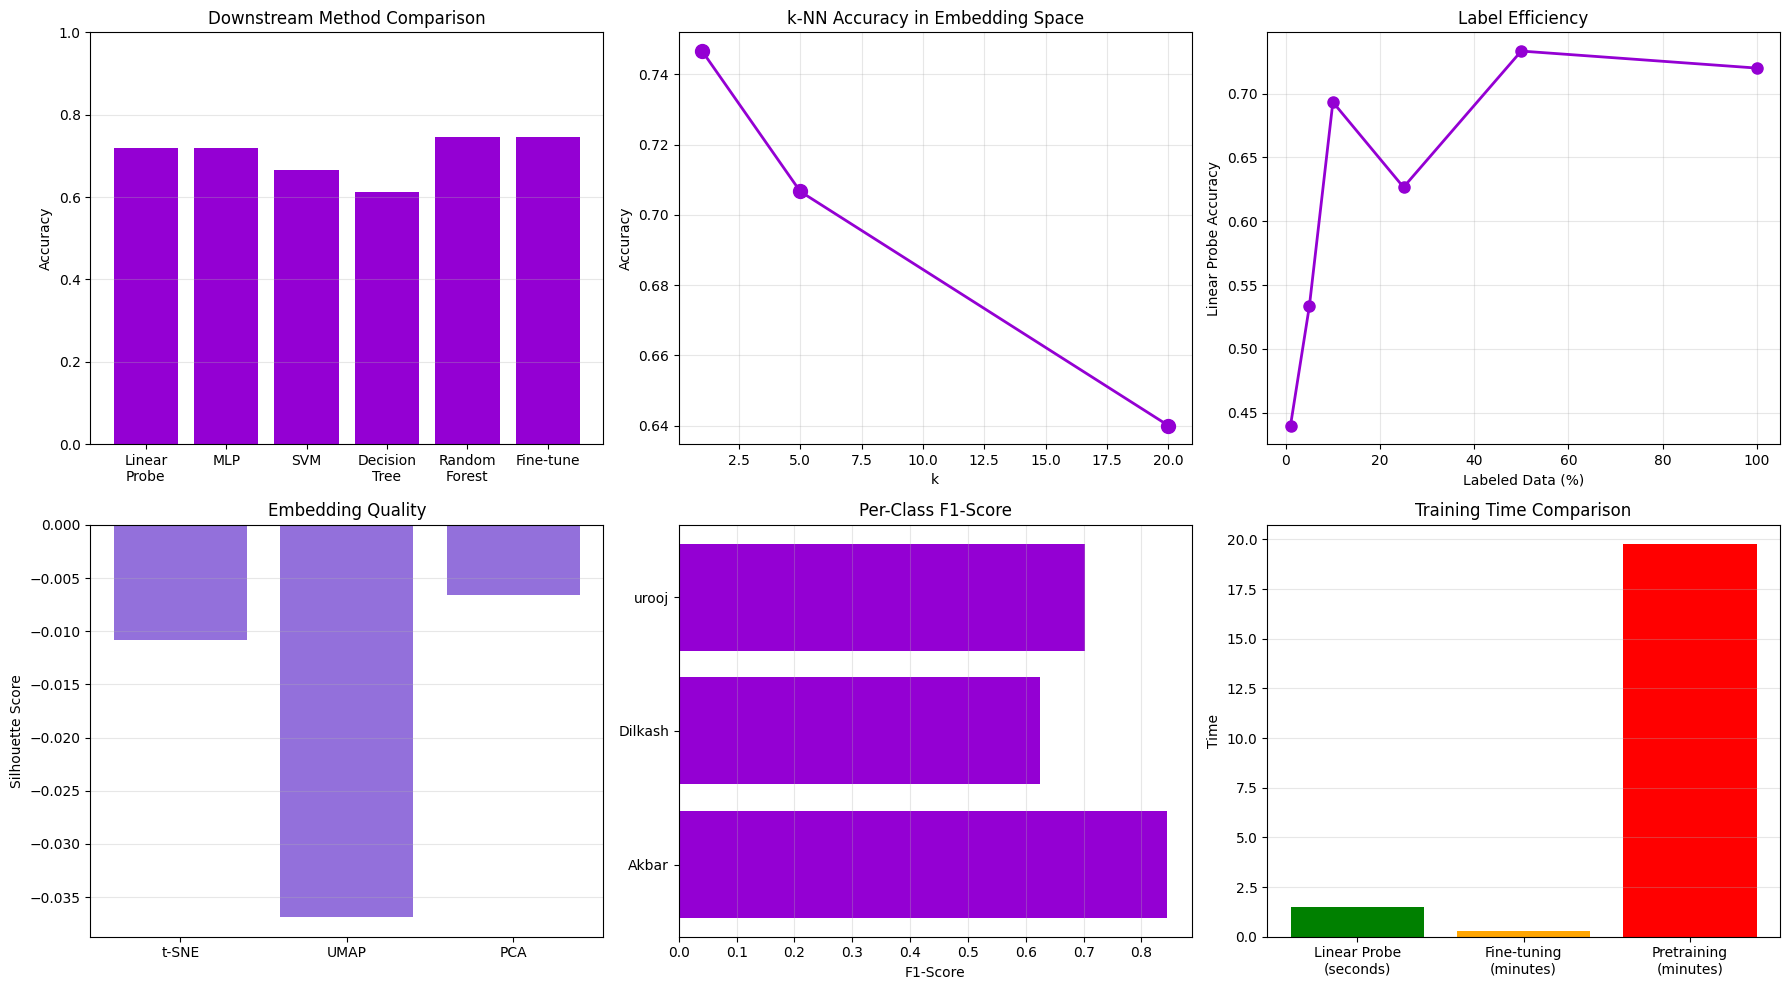

In [26]:
def plot_comprehensive_comparison():
    """
    Create comprehensive visualization of all evaluation metrics
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # 1. Method Comparison
    methods = ['Linear\nProbe', 'MLP', 'SVM', 'Decision\nTree', 
               'Random\nForest', 'Fine-tune']
    accuracies = [
        linear_acc,
        shallow_results['MLP']['accuracy'],
        shallow_results['SVM']['accuracy'],
        shallow_results['DecisionTree']['accuracy'],
        shallow_results['RandomForest']['accuracy'],
        finetune_acc
    ]

    axes[0, 0].bar(methods, accuracies, color='darkviolet')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_title('Downstream Method Comparison')
    axes[0, 0].set_ylim([0, 1])
    axes[0, 0].grid(axis='y', alpha=0.3)

    # 2. k-NN Accuracy
    k_vals = list(knn_results.keys())
    k_accs = list(knn_results.values())
    axes[0, 1].plot(k_vals, k_accs, marker='o', linewidth=2, markersize=10, color='darkviolet')
    axes[0, 1].set_xlabel('k')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('k-NN Accuracy in Embedding Space')
    axes[0, 1].grid(alpha=0.3)

    # 3. Label Efficiency
    fracs = [f * 100 for f in label_efficiency_results.keys()]
    le_accs = list(label_efficiency_results.values())
    axes[0, 2].plot(fracs, le_accs, marker='o', linewidth=2, markersize=8, color='darkviolet')
    axes[0, 2].set_xlabel('Labeled Data (%)')
    axes[0, 2].set_ylabel('Linear Probe Accuracy')
    axes[0, 2].set_title('Label Efficiency')
    axes[0, 2].grid(alpha=0.3)

    # 4. Silhouette Scores
    emb_methods = ['t-SNE', 'UMAP', 'PCA']
    sil_scores = [tsne_sil, umap_sil, pca_sil]
    axes[1, 0].bar(emb_methods, sil_scores, color='mediumpurple')
    axes[1, 0].set_ylabel('Silhouette Score')
    axes[1, 0].set_title('Embedding Quality')
    axes[1, 0].grid(axis='y', alpha=0.3)

    # 5. Per-Class F1 Scores
    axes[1, 1].barh(class_names, metrics['f1'], color='darkviolet')
    axes[1, 1].set_xlabel('F1-Score')
    axes[1, 1].set_title('Per-Class F1-Score')
    axes[1, 1].grid(axis='x', alpha=0.3)

    # 6. Training Time Comparison
    times = [lp_train_time, ft_train_time/60, pretrain_time/60]
    time_labels = ['Linear Probe\n(seconds)', 
                   'Fine-tuning\n(minutes)', 
                   'Pretraining\n(minutes)']
    colors = ['green', 'orange', 'red']
    axes[1, 2].bar(time_labels, times, color=colors)
    axes[1, 2].set_ylabel('Time')
    axes[1, 2].set_title('Training Time Comparison')
    axes[1, 2].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('comprehensive_metrics_barlow_twins.png', dpi=150, bbox_inches='tight')
    plt.show()


# Call the function
plot_comprehensive_comparison()
